##Imports

In [4]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

##Building the Word vocab

Use the kendrick lyrics dataset you created. 

In [5]:
#load the dataset
data = open('./kendrick.txt').read()

#Lowercase and split the text
corpus = data.lower().split('\n')

#Preview the result
print(corpus)

['\ufeffi am a sinner', "who's probably gonna sin again", 'lord forgive me', 'lord forgive me', "things i don't understand", 'sometimes i need to be alone', "bitch don't kill my vibe", "bitch don't kill my vibe", 'i can feel your energy from two planets away', "i got my drink i got my music i would share it but today i'm yelling", "bitch don't kill my vibe", "bitch don't kill my vibe", "bitch don't kill my vibe", "bitch don't kill my vibe", 'look inside of my soul and you can find gold and maybe get rich', 'look inside of your soul and you can find out it never exist', 'i can feel the changes', 'i can feel a new life', 'i always knew life can be dangerous', "i can say that i like a challenge and you tell me it's painless", "you don't know what pain is", 'how can i paint this picture', 'when the color blind is hanging with ya', 'fell on my face and i woke with a scar', 'another mistake living deep in my heart', 'wear it on top of my sleeve in a flick', 'i can admit that it did look like

From here, initialize the `Tokenizer` class and generate the word index dictionary

In [6]:
#Initialize the Tokenizer class
tokenizer = Tokenizer()

#Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

#Define the total words. You add 1 for index '0' which is just the padding
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'the': 1, 'i': 2, 'a': 3, 'and': 4, 'you': 5, 'my': 6, 'me': 7, 'to': 8, 'of': 9, 'in': 10, 'that': 11, 'is': 12, 'your': 13, 'on': 14, "i'm": 15, 'it': 16, "don't": 17, 'just': 18, 'with': 19, 'bitch': 20, 'can': 21, 'this': 22, 'all': 23, 'ya': 24, 'at': 25, 'kill': 26, 'vibe': 27, 'bish': 28, 'got': 29, 'we': 30, 'how': 31, 'up': 32, 'feel': 33, "that's": 34, 'but': 35, 'nigga': 36, 'out': 37, 'know': 38, 'like': 39, 'tell': 40, 'when': 41, 'see': 42, 'one': 43, 'from': 44, 'what': 45, 'they': 46, 'for': 47, 'nah': 48, 'be': 49, "ain't": 50, 'was': 51, 'dollar': 52, 'say': 53, 'then': 54, 'no': 55, 'or': 56, 'fuck': 57, 'where': 58, 'if': 59, 'way': 60, 'now': 61, 'do': 62, 'them': 63, 'he': 64, 'said': 65, 'him': 66, "it's": 67, 'go': 68, 'never': 69, 'every': 70, 'time': 71, 'day': 72, 'might': 73, 'his': 74, 'down': 75, 'need': 76, 'city': 77, 'hit': 78, 'gun': 79, 'so': 80, 'lord': 81, 'forgive': 82, 'two': 83, 'away': 84, 'would': 85, 'inside': 86, 'get'

##Pre-Processing the data

Next generate the inputs and labels for the model. The process is identical to the irish lyrics model. The `xs` or inputs to the model will padded sequences, while the  `ys` or labels are one-hot encoded arrays

In [7]:
#Initialize the sequences list
input_sequences = []

#Loop over every line 
for line in corpus:

  #Tokenize the current line 
  token_list = tokenizer.texts_to_sequences([line])[0]

  #Loop over the line several times to generate the subphrases 
  for i in range(1, len(token_list)):

    #Generate the subphrase 
    n_gram_sequence = token_list[:i+1]

    #Append the subphrase to the sequences list
    input_sequences.append(n_gram_sequence)

#Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

#Pad all sequences 
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding='pre'))

#Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

#Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes = total_words)

In [8]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence: 
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['\ufeffi', 'am', 'a', 'sinner']
[443, 115, 3, 181]


##Build and compile the model 

Use the hyperparameters at the top of the code cell to easily tweak the model

In [9]:
#Hyperparameters 
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

#Build the model 
model = Sequential([
      Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
      Bidirectional(LSTM(lstm_units)),
      Dense(total_words, activation = 'softmax')
])

model.compile(
      loss = 'categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
      metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 100)           116400    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1164)              350364    
                                                                 
Total params: 767,964
Trainable params: 767,964
Non-trainable params: 0
_________________________________________________________________


##Train the model 
Make sure to activate the GPU when you train the model so that it runs fast enough. 

In [10]:
epochs = 50

#Train the model 
history = model.fit(xs, ys, epochs = epochs)

Epoch 1/250
113/113 [==============================] - 8s 9ms/step - loss: 6.2384 - accuracy: 0.0547
Epoch 2/250
113/113 [==============================] - 1s 8ms/step - loss: 5.0048 - accuracy: 0.1577
Epoch 3/250
113/113 [==============================] - 1s 8ms/step - loss: 3.6458 - accuracy: 0.3005
Epoch 4/250
113/113 [==============================] - 1s 8ms/step - loss: 2.3550 - accuracy: 0.4690
Epoch 5/250
113/113 [==============================] - 1s 8ms/step - loss: 1.3146 - accuracy: 0.6937
Epoch 6/250
113/113 [==============================] - 1s 8ms/step - loss: 0.7338 - accuracy: 0.8320
Epoch 7/250
113/113 [==============================] - 1s 7ms/step - loss: 0.4517 - accuracy: 0.8989
Epoch 8/250
113/113 [==============================] - 1s 8ms/step - loss: 0.3324 - accuracy: 0.9181
Epoch 9/250
113/113 [==============================] - 1s 8ms/step - loss: 0.2999 - accuracy: 0.9217
Epoch 10/250
113/113 [==============================] - 1s 8ms/step - loss: 0.2673 - accura

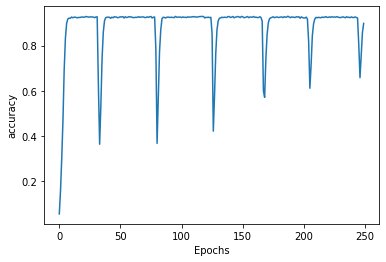

In [11]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

##Generating text 
Now let the model make its own songs. The results should be less repetative since it was trained on a larger corpus.

In [17]:
#Define the seed tex
seed_text = "fuck it up"

#Define the total words to predict 
next_words = 100


#Loop until desired length is reached 
for _ in range(next_words):

  #Convert the seed text to a token sequence 
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

  #Pad the sequence 
  token_list = pad_sequences([token_list], maxlen = max_sequence_len - 1, padding = 'pre')

  #Feed to the model and get the probabilities of each index
  probabilities = model.predict(token_list)

  #Get the index witht the highest probability
  predicted = np.argmax(probabilities, axis = -1)[0]

  #Ignore if index is 0 since that is just padding 
  if predicted != 0:

    #Look up the word associated with the index
    output_word = tokenizer.index_word[predicted]

    #Combine with seed phrase
    seed_text += " " + output_word

print(seed_text)

fuck it up you say my intelligence now is great relief crack a bird and i am a sinner maybe get he why i rarely go to sleep at night on obituary down what is actin' unsensitive and burned to coal pack that my mortal halle said where him could forever tweaking then i watch you when until he finally asked him feelin' some even burger stand thug you i exist in a lightskinned nigga with cocaine residue burned all on his say you ya bish ya bish ya bish ya bish ya bish ya bish ya bish ya bish ya bish ya
